In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.model_selection import learning_curve

from IPython.display import display, Latex

%matplotlib inline
%config InlineBackend.figure_format='retina'
#!pip install git+https://github.com/M-Bianchi/My_matplotlib_style
plt.style.use('mystyle')

## Time to get your hands dirty! Supernova distances and redshifts (part 2)

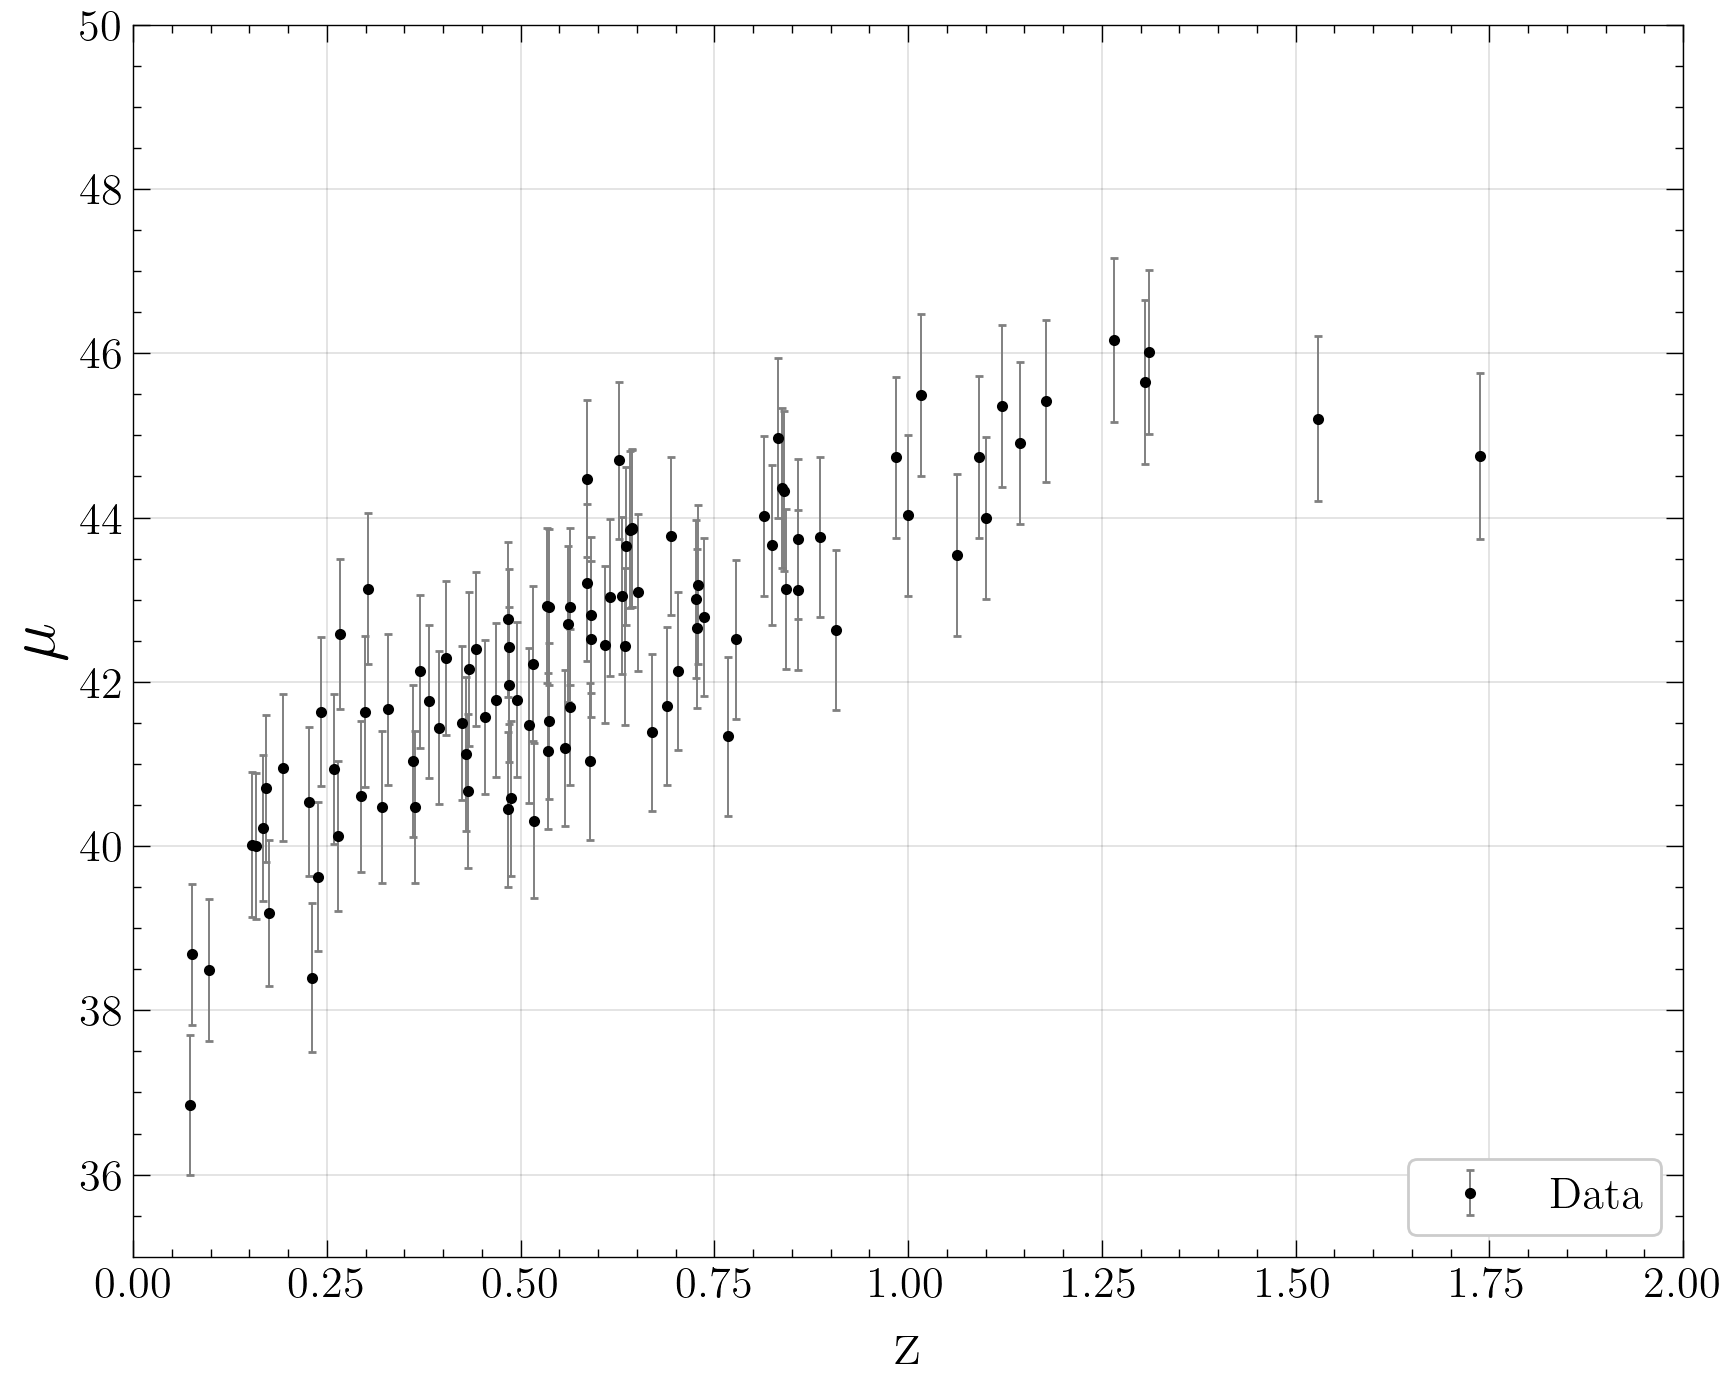

In [2]:
from astroML.datasets import generate_mu_z

N = 100
z_sample, mu_sample, dmu = generate_mu_z(N, random_state=1234)

plt.figure(figsize=(10,8))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=0.7, label='Data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

First let's fit our supernova synthetic data from last time using GPR.

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)

We now have a suite of **data-driven** predictive models for our supernova dataset (from polynomials to GPR). That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You  might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM. We can do a **parametric** fit (and hopehully by now the difference between "parametric" and "data driven" fit is clear in your head)

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). I got:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$


- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fit it to the data (however you want to do it, are you frequentist or Bayesian after all?).
- What are the measured value of $H_0$ and $\Omega_m$. Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much much better.
- Think about the pdf of these data in $z$.
- Using both the GPR fit and your latest $\Lambda$CDM fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given. 



# Code

## 1) Gaussian Process Regression

### 1.1) Radial basis function (aka squared-exponential kernel)

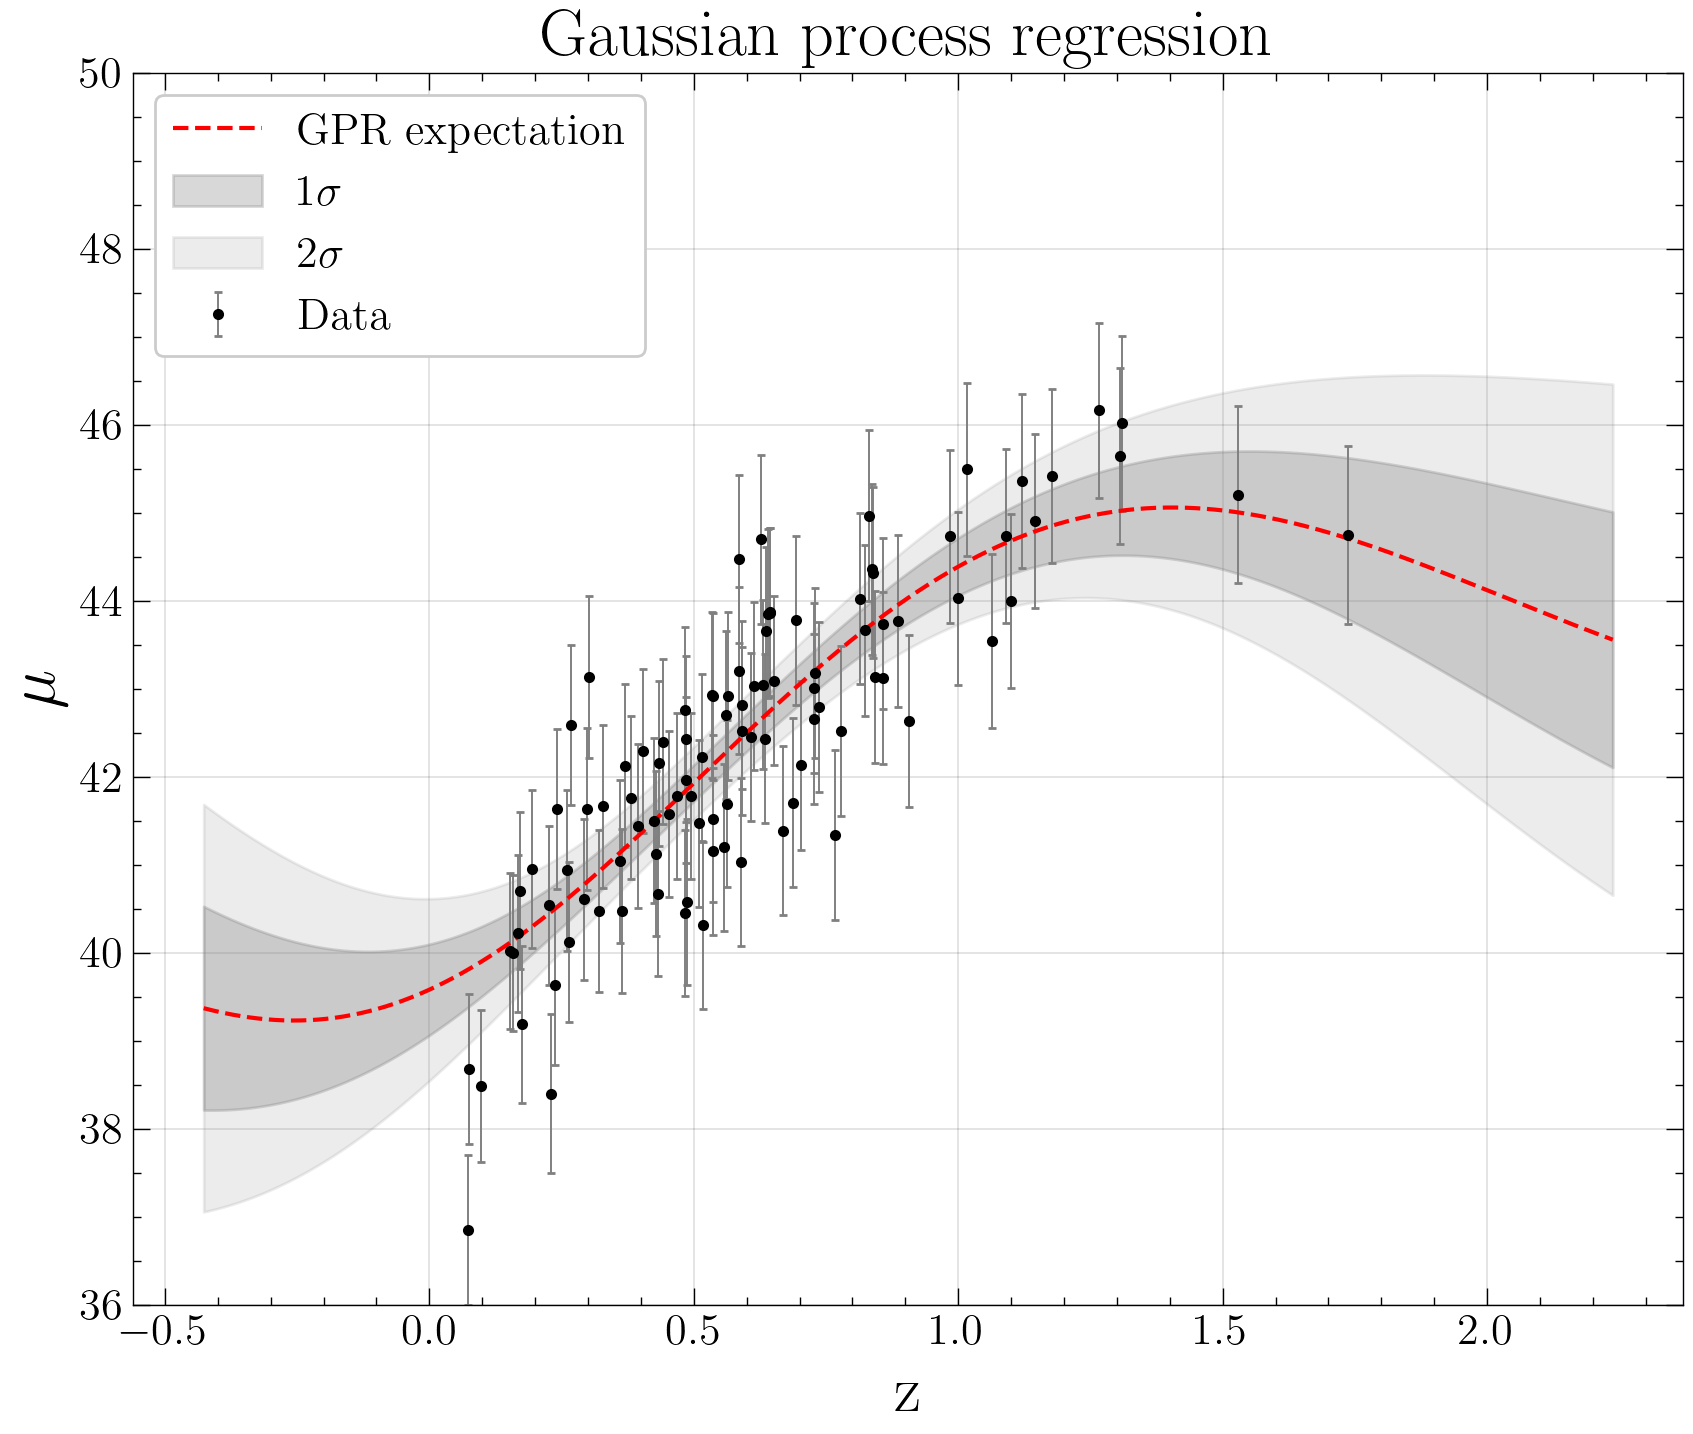

In [5]:
kernel = kernels.RBF()
gpr = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2, normalize_y=True, n_restarts_optimizer=10)
gpr.fit(z_sample[:, np.newaxis], mu_sample)

x_dense = np.linspace(np.min(z_sample)-0.5, np.max(z_sample)+0.5, 1000)
y_pred, y_pred_err = gpr.predict(x_dense[:, np.newaxis], return_std=True)

plt.figure(figsize=(10,8))
plt.title('Gaussian process regression')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=0.7, label='Data')
plt.plot(x_dense, y_pred, ls='--', color='red', label='GPR expectation')
plt.fill_between(x_dense, y_pred - y_pred_err, y_pred + y_pred_err, color='gray', alpha=0.3, label='$1\sigma$')
plt.fill_between(x_dense, y_pred - 2*y_pred_err, y_pred + 2*y_pred_err, color='gray', alpha=0.15, label='$2\sigma$')
plt.ylim(36, 50)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='upper left');

### 1.2) Radial basis function + Constant

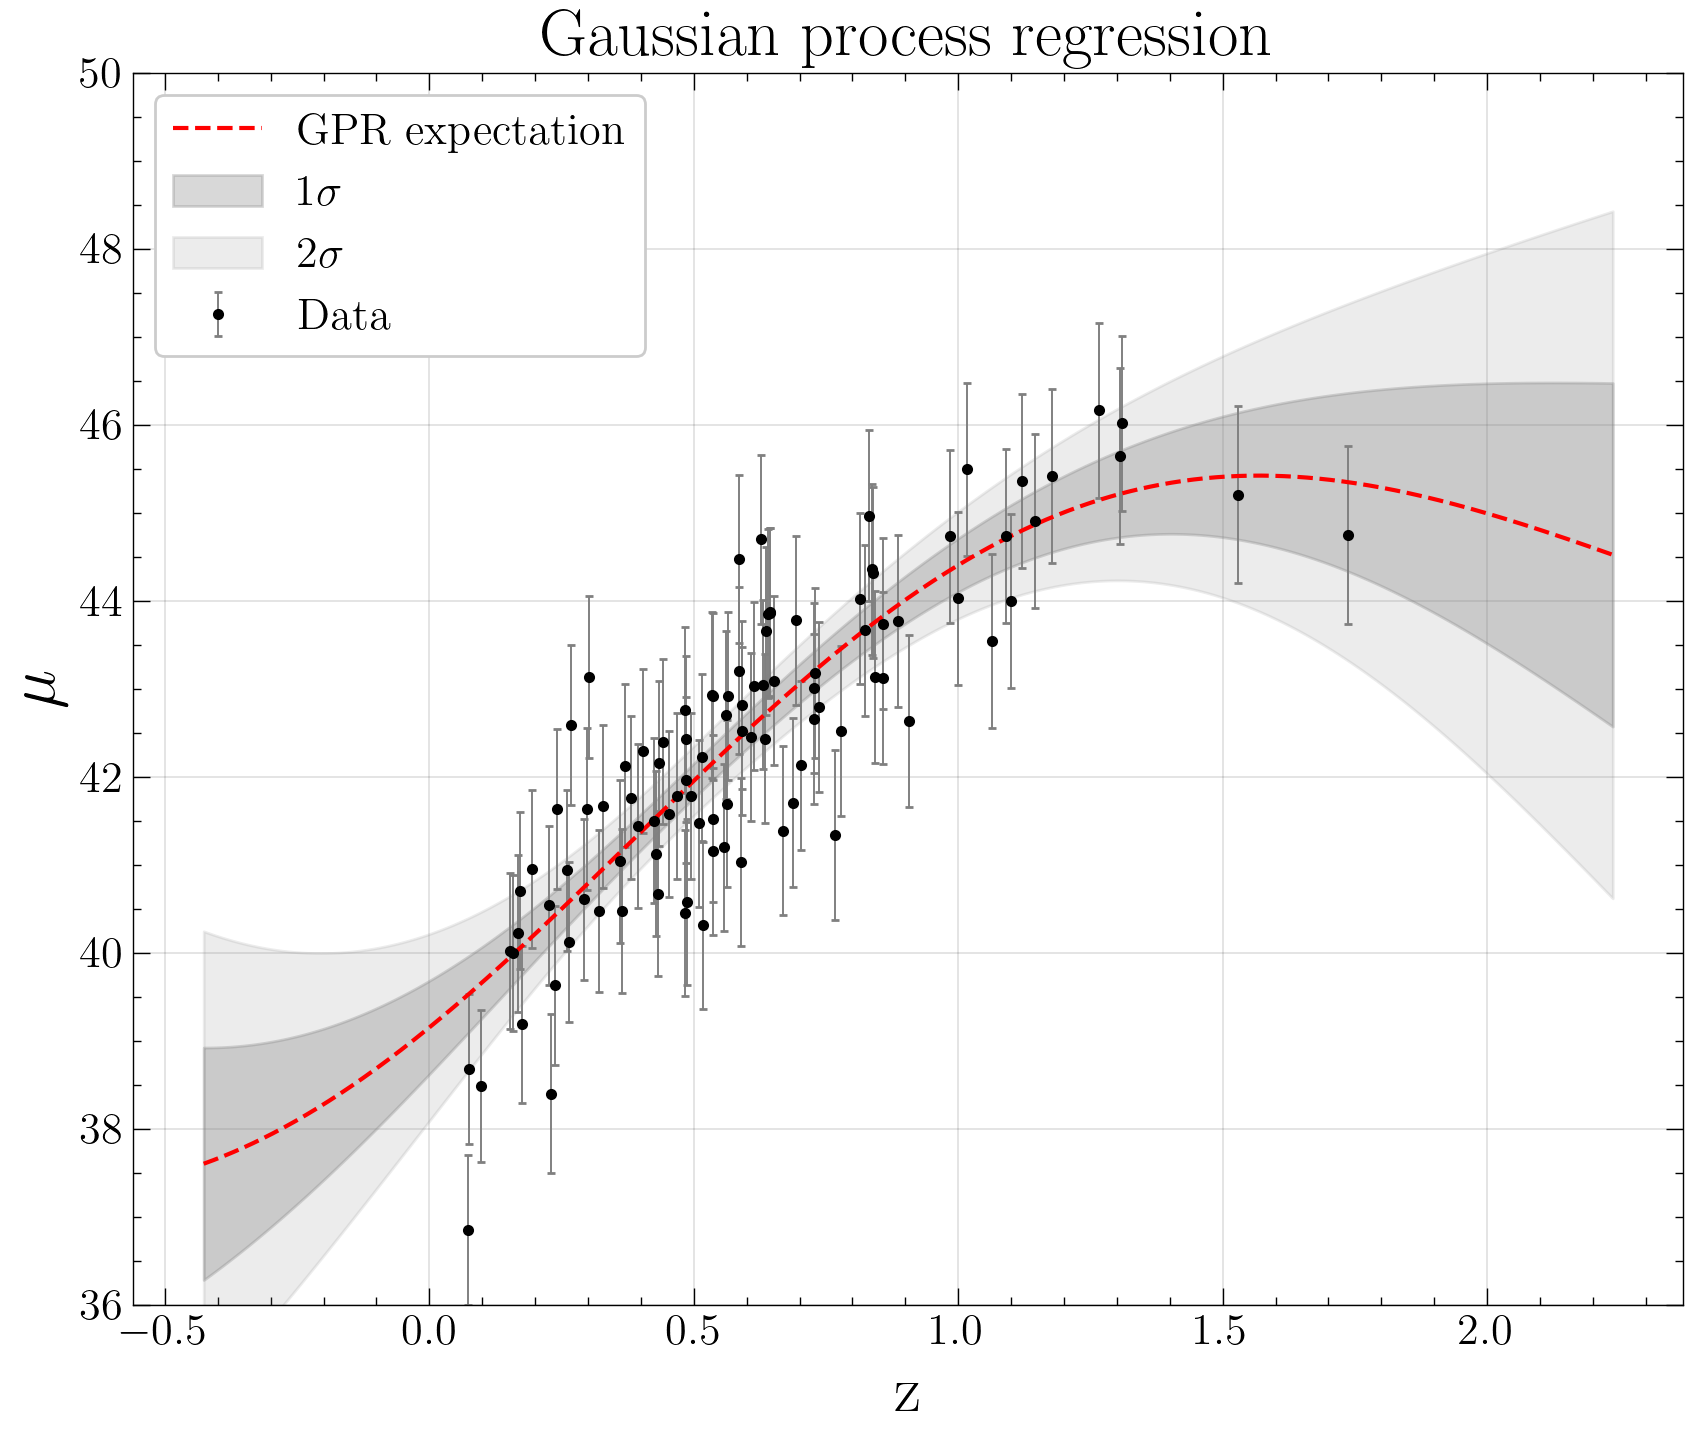

In [7]:
kernel = kernels.ConstantKernel() * kernels.RBF()
gpr = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2, normalize_y=True, n_restarts_optimizer=10)
gpr.fit(z_sample[:, np.newaxis], mu_sample)

x_dense = np.linspace(np.min(z_sample)-0.5, np.max(z_sample)+0.5, 1000)
y_pred, y_pred_err = gpr.predict(x_dense[:, np.newaxis], return_std=True)

plt.figure(figsize=(10,8))
plt.title('Gaussian process regression')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=0.7, label='Data')
plt.plot(x_dense, y_pred, ls='--', color='red', label='GPR expectation')
plt.fill_between(x_dense, y_pred - y_pred_err, y_pred + y_pred_err, color='gray', alpha=0.3, label='$1\sigma$')
plt.fill_between(x_dense, y_pred - 2*y_pred_err, y_pred + 2*y_pred_err, color='gray', alpha=0.15, label='$2\sigma$')
plt.ylim(36, 50)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='upper left');